In [6]:
from Gao_Algorithm import * 
import matplotlib.pyplot as plt
import random
import pandas as pd
random.seed(30)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import NearestNeighbors
import datafold
from datafold.pcfold import PCManifold
from datafold.pcfold import kernels
from datafold.pcfold import estimate_scale
import GPy
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

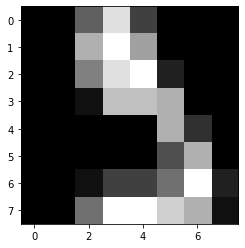

9


(1797, 64)

In [2]:
digits = load_digits()
plt.gray() 
plt.imshow(digits.images[19]) 
plt.show() 
print(digits.target[19])
data = np.array(digits['data']) 
data = data / 255.0
digits.data.shape

In [3]:
n_classes = 10

print("Classes: ", np.unique(digits.target))
print("Number of points per class:", [np.sum(digits.target==k) for k in np.unique(digits.target)])

random_state = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=test_size, random_state=random_state)

# note that y_test and X_test is never used below.

Classes:  [0 1 2 3 4 5 6 7 8 9]
Number of points per class: [178, 182, 177, 183, 181, 182, 181, 179, 174, 180]


In [4]:
#####DIVIDING DATASETS INTO BATCHES ##### 

#num_lmk = 125          # how many landmarks to find in total
num_lmk_per_batch = 30 # how many landmarks to find per batch
batch_size = 50       # points per batch
n_batches = 3 # number of batches chosen per class

total_landmarks = np.array([])
idx_all = np.arange(X_train.shape[0])

# define a random number generator and use it to draw samples for batching
_rng = np.random.default_rng(random_state)
x = []
x_labels = []
for current_class in np.unique(y_train):
    
    # setup the dataset for the current class
    idx_class = (y_train == current_class)
    X_train_class = X_train[idx_class, :]
    y_train_class = y_train[idx_class]
    total_landmarks_class = np.array([])
    
    print(f"Number of points in class {current_class}: {X_train_class.shape[0]}")
    
    for _ in range(n_batches):
    
        # draw new batch at random
        batch_indices = _rng.choice(X_train_class.shape[0], size=(batch_size,))
        cat_data = X_train_class[batch_indices,:]
        x.append(cat_data)
        x_labels.append(y_train_class[batch_indices])
        # append the previous landmark data points to the array so that we can use them for the next landmarking call
        if len(total_landmarks_class) > 0:
            cat_data = np.row_stack([X_train_class[total_landmarks_class,:], cat_data])
        print(f"cat_data shape: {cat_data.shape[0]}")
        (GPLmkIdx, ptuq) = GetGPLmk_Euclidean(cat_data, num_lmk_per_batch, batch_size, BNN = 10, len(total_landmarks_class))
        # clean up the new indices by removing the ones we know
        GPLmkIdx = GPLmkIdx[len(total_landmarks_class):] - len(total_landmarks_class)
        GPLmkIdx = GPLmkIdx[GPLmkIdx >= 0]
        # add the new indices to the old ones
        unique_new_landmarks = np.unique(batch_indices[GPLmkIdx])
        total_landmarks_class = np.concatenate([total_landmarks_class, unique_new_landmarks]).astype(np.int)
    
    print(f"Found {len(total_landmarks_class)} landmarks for class {current_class}.")
    
    total_landmarks = np.concatenate([total_landmarks, idx_all[idx_class][total_landmarks_class]]).astype(np.int)
    
print(f"Total number of landmarks: {len(total_landmarks)}")
tot_landmarks = np.array(total_landmarks)
tot_landmarks = tot_landmarks.reshape(-1, )
x = np.array(x)
x = x.reshape(10 * n_batches * batch_size, -1)
x_labels = np.array(x_labels)
x_labels = x_labels.reshape(-1, )

Number of points in class 0: 145
cat_data shape: 50
cat_data shape: 63
cat_data shape: 65
Found 16 landmarks for class 0.
Number of points in class 1: 154
cat_data shape: 50
cat_data shape: 68
cat_data shape: 72
Found 24 landmarks for class 1.
Number of points in class 2: 144
cat_data shape: 50
cat_data shape: 65
cat_data shape: 68
Found 22 landmarks for class 2.
Number of points in class 3: 149
cat_data shape: 50
cat_data shape: 65
cat_data shape: 68
Found 22 landmarks for class 3.
Number of points in class 4: 135
cat_data shape: 50
cat_data shape: 61
cat_data shape: 63
Found 18 landmarks for class 4.
Number of points in class 5: 135
cat_data shape: 50
cat_data shape: 63
cat_data shape: 65
Found 19 landmarks for class 5.
Number of points in class 6: 146
cat_data shape: 50
cat_data shape: 66
cat_data shape: 71
Found 23 landmarks for class 6.
Number of points in class 7: 145
cat_data shape: 50
cat_data shape: 62
cat_data shape: 67
Found 22 landmarks for class 7.
Number of points in clas

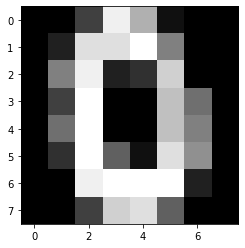

3

In [7]:
a = 1
plt.gray() 
plt.imshow(x[a, :].reshape(8, 8)) 
plt.show()
x_labels[a]

In [6]:
encoder = OneHotEncoder(sparse=False)
onehot = encoder.fit_transform(x_labels.reshape(-1, 1))
onehot

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [7]:
number_of_classes = 10
m = [GPy.models.GPClassification(x,onehot[:,i].reshape(-1,1)) for i in range(0, number_of_classes)]

'\nm_0 = GPy.models.GPClassification(x,onehot[:,0].reshape(-1,1))\nm_1 = GPy.models.GPClassification(x,onehot[:,1].reshape(-1,1))\nm_2 = GPy.models.GPClassification(x,onehot[:,2].reshape(-1,1))\nm_3 = GPy.models.GPClassification(x,onehot[:,3].reshape(-1,1))\nm_4 = GPy.models.GPClassification(x,onehot[:,4].reshape(-1,1))\nm_5 = GPy.models.GPClassification(x,onehot[:,5].reshape(-1,1))\nm_6 = GPy.models.GPClassification(x,onehot[:,6].reshape(-1,1))\nm_7 = GPy.models.GPClassification(x,onehot[:,7].reshape(-1,1))\nm_8 = GPy.models.GPClassification(x,onehot[:,8].reshape(-1,1))\nm_9 = GPy.models.GPClassification(x,onehot[:,9].reshape(-1,1))\n'

In [8]:
for m_ in m:
    m_.optimize()
average_variance = np.average([m_.rbf.variance[0] for m_ in m])
average_lengthscale = np.average([m_.rbf.lengthscale[0] for m_ in m])

'\nm_0.optimize()\nm_1.optimize()\nm_2.optimize()\nm_3.optimize()\nm_4.optimize()\nm_5.optimize()\nm_6.optimize()\nm_7.optimize()\nm_8.optimize()\nm_9.optimize()\n'

In [ ]:
average_lengthscale

In [9]:
def landmark_gp_clustering_accuracy(landmarks, landmark_labels, coords, y):
    if(landmarks.shape[0] < 10):
        return 0
    kernel = average_variance * RBF(average_lengthscale)
    gpc = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(landmarks, landmark_labels)
    predicted_labels = gpc.predict(coords)
    print("Landmarks: ", landmarks.shape[0], "Accuracy: ", accuracy_score(y, predicted_labels))
    return accuracy_score(y, predicted_labels)

In [10]:
np.random.shuffle(tot_landmarks)

In [11]:
accuracies_gp = [landmark_gp_clustering_accuracy(X_train[tot_landmarks[:i], :], y_train[tot_landmarks[:i]], X_test, y_test) for i in range(0, tot_landmarks.shape[0], 1)]

Landmarks:  10 Accuracy:  0.125
Landmarks:  11 Accuracy:  0.24722222222222223
Landmarks:  12 Accuracy:  0.25833333333333336
Landmarks:  13 Accuracy:  0.35
Landmarks:  14 Accuracy:  0.34444444444444444
Landmarks:  15 Accuracy:  0.33611111111111114
Landmarks:  16 Accuracy:  0.33611111111111114
Landmarks:  17 Accuracy:  0.33611111111111114
Landmarks:  18 Accuracy:  0.36666666666666664
Landmarks:  19 Accuracy:  0.4027777777777778
Landmarks:  20 Accuracy:  0.41944444444444445
Landmarks:  21 Accuracy:  0.4666666666666667
Landmarks:  22 Accuracy:  0.5083333333333333
Landmarks:  23 Accuracy:  0.5166666666666667
Landmarks:  24 Accuracy:  0.5861111111111111
Landmarks:  25 Accuracy:  0.5472222222222223
Landmarks:  26 Accuracy:  0.55
Landmarks:  27 Accuracy:  0.5777777777777777
Landmarks:  28 Accuracy:  0.55
Landmarks:  29 Accuracy:  0.6277777777777778
Landmarks:  30 Accuracy:  0.6472222222222223
Landmarks:  31 Accuracy:  0.7305555555555555
Landmarks:  32 Accuracy:  0.7333333333333333
Landmarks:  

Landmarks:  197 Accuracy:  0.9166666666666666
Landmarks:  198 Accuracy:  0.9194444444444444
Landmarks:  199 Accuracy:  0.9194444444444444
Landmarks:  200 Accuracy:  0.9194444444444444
Landmarks:  201 Accuracy:  0.9194444444444444
Landmarks:  202 Accuracy:  0.9194444444444444
Landmarks:  203 Accuracy:  0.9166666666666666
Landmarks:  204 Accuracy:  0.9166666666666666
Landmarks:  205 Accuracy:  0.9166666666666666


In [12]:
def landmark_clustering_accuracy(landmarks, landmarks_labels, coords, y):
    if(landmarks.shape[0] < 10):
        return 0
    knn_land = KNeighborsClassifier(n_neighbors=1).fit(landmarks, landmarks_labels)
    predicted_labels = knn_land.predict(coords)
    print("Landmarks: ", landmarks.shape[0], "Accuracy: ", accuracy_score(y, predicted_labels))
    return accuracy_score(y, predicted_labels)

In [13]:
accuracies_knn = [landmark_clustering_accuracy(X_train[tot_landmarks[:i], :], y_train[tot_landmarks[:i]], X_test, y_test) for i in range(0, tot_landmarks.shape[0], 1)]

Landmarks:  10 Accuracy:  0.45
Landmarks:  11 Accuracy:  0.4722222222222222
Landmarks:  12 Accuracy:  0.5416666666666666
Landmarks:  13 Accuracy:  0.55
Landmarks:  14 Accuracy:  0.625
Landmarks:  15 Accuracy:  0.6472222222222223
Landmarks:  16 Accuracy:  0.6333333333333333
Landmarks:  17 Accuracy:  0.6305555555555555
Landmarks:  18 Accuracy:  0.6388888888888888
Landmarks:  19 Accuracy:  0.6416666666666667
Landmarks:  20 Accuracy:  0.6444444444444445
Landmarks:  21 Accuracy:  0.6611111111111111
Landmarks:  22 Accuracy:  0.6555555555555556
Landmarks:  23 Accuracy:  0.6805555555555556
Landmarks:  24 Accuracy:  0.6833333333333333
Landmarks:  25 Accuracy:  0.6833333333333333
Landmarks:  26 Accuracy:  0.6861111111111111
Landmarks:  27 Accuracy:  0.6861111111111111
Landmarks:  28 Accuracy:  0.6861111111111111
Landmarks:  29 Accuracy:  0.725
Landmarks:  30 Accuracy:  0.7805555555555556
Landmarks:  31 Accuracy:  0.7944444444444444
Landmarks:  32 Accuracy:  0.8027777777777778
Landmarks:  33 Accu

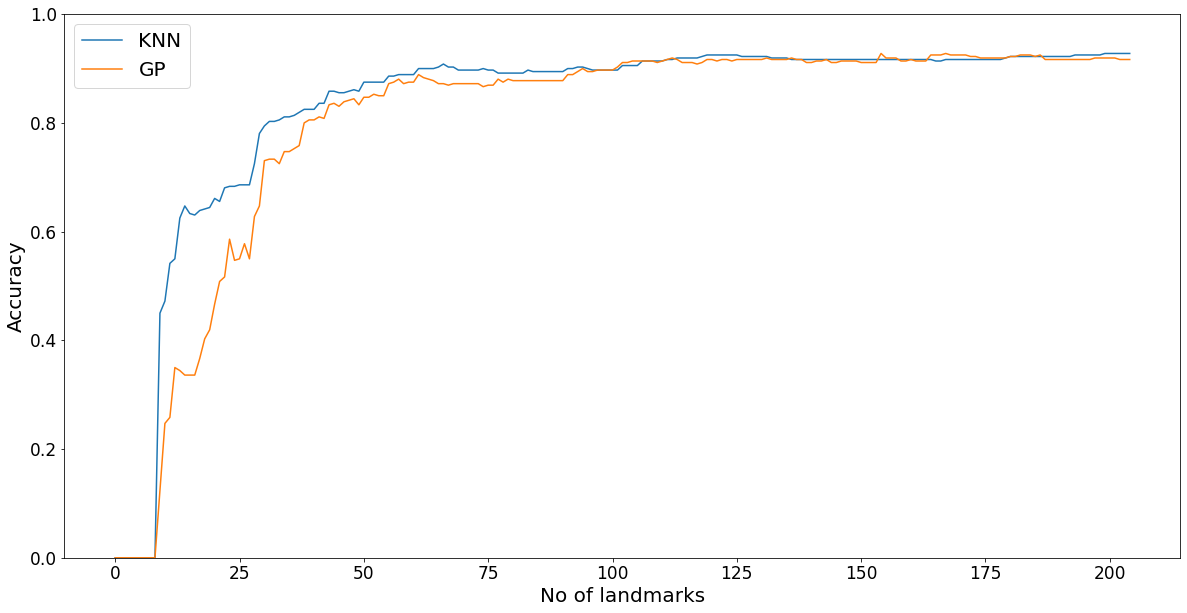

In [6]:
fig = plt.figure(figsize=(20, 10))
plt.plot(range(0, tot_landmarks.shape[0], 1), accuracies_knn, label = "KNN")
plt.plot(range(0, tot_landmarks.shape[0], 1), accuracies_gp, label = "GP")
plt.xlabel('No of landmarks' ,fontsize=20)
plt.ylabel('Accuracy' ,fontsize=20)
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.ylim(0, 1.0)
plt.show()
fig.savefig('conc_landmarks_gao_sklearn.png')